In [1]:
# import and dataset loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from kneed import KneeLocator
from yellowbrick.cluster import SilhouetteVisualizer
import warnings

warnings.filterwarnings('ignore')

dataset = pd.read_csv("example_dataset.csv")

In [2]:
base_path="./"
def fasttextPreTrained(vecfile):
    """
    Creates a dictionary in which every character, bigram or trigram is associated with a numeric vector
    :param vecfile: str
        String representing path in which FastText vecfile is located
    :return: embeddings_index: dict
        Dictionary containing the vectorization of characters,bigrams or trigrams
        key: character,bigram or trigram
        value: numeric vector associated to key
    """
    ######################################
    # EMBEDDING LAYER
    #####################################
    embeddings_index = {}
    f = open(vecfile, "r")
    next(f)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index

In [3]:
#fasttext embedding
dim=3
dict_skipgram = fasttextPreTrained(f"{base_path}/fasttext.vec")
domain_names = dataset["bigrams"].to_numpy()
max_len = np.max([len(x.split()) for x in domain_names])
embedded_domain_names = []
for name in domain_names:
    sequences = np.array(
        [dict_skipgram.get(token) if dict_skipgram.get(token) is not None else np.zeros(dim)
         for token in name.split()], dtype=np.single)
    pad = np.zeros(dim * (max_len - len(name.split())), dtype=np.single)
    embedded_domain_name = np.concatenate((sequences, pad), axis=None, dtype=np.single)
    embedded_domain_names.append(embedded_domain_name)
embedded_domain_names_df = pd.DataFrame(embedded_domain_names)
print(embedded_domain_names_df)

Found 1330 word vectors.
           0         1         2         3         4         5         6     
0    -1.605471 -0.541829  0.454933 -1.379988 -0.788692  0.552011 -1.713197  \
1    -1.213661  0.009734  0.386734 -1.510524 -0.781731  0.542584 -1.334171   
2    -0.186788 -1.058991  1.166266 -0.571405 -1.136771  0.955850 -0.339861   
3    -0.546095 -1.176629  0.982990 -1.479382 -0.756001  0.544511 -1.299846   
4    -1.406574 -0.231876  0.401584 -1.345296 -0.212878  0.418042 -1.510738   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.478042  0.108911  1.802896 -1.270431  0.537538  0.375591 -1.237653   
9996 -0.436019  0.900982  0.707289 -0.471186  1.034299  0.715073 -0.573766   
9997 -0.501045  1.161803  0.704084 -0.351755  1.220803  0.862170 -0.981011   
9998  0.245739  0.393291  1.349615  0.505329  0.165129  1.882091  0.555169   
9999  0.194090  0.431672  1.269560  0.463730  0.216568  1.789202 -0.062246   

           7         8         9    ..

In [24]:
true_labels_biclass = list(dataset['label'])
# etichette multiclasse
families = set(dataset["label_multiclass"])
families.remove("legit")
family_dict = {}
family_dict.update({"legit": 0})
family_dict.update({family: i for i, family in enumerate(sorted(families), 1)})
print(family_dict)
true_labels_multi = [family_dict[family] for family in dataset["label_multiclass"].to_numpy()]

{'legit': 0, 'cryptolocker': 1, 'dircrypt': 2, 'dyre': 3, 'padcrypt': 4, 'zeus-newgoz': 5}


Text(0, 0.5, 'wcss')

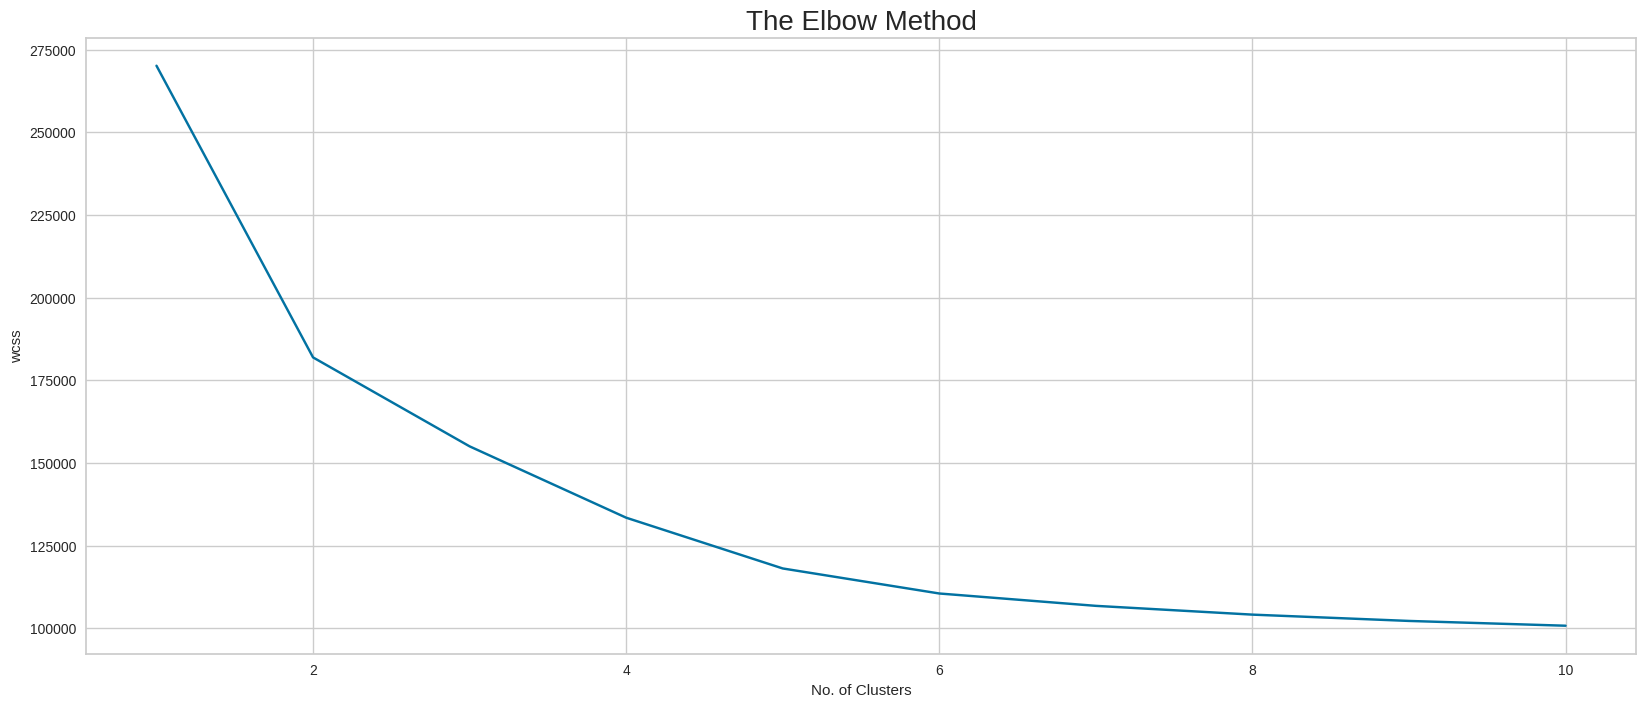

In [5]:
#kmeans
wcss=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k)
    cluster=kmeans.fit(embedded_domain_names)
    wcss.append(cluster.inertia_)
plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

Stats KMeans:
Silhouette: 0.49430781602859497
Homogeneity with two classes: 0.10931967751941274
Completeness with two classes: 0.23137769464071678
V-measure with two classes: 0.14848447349585037
Homogeneity with six classes: 0.21459757878189623
Completeness with six classes: 0.9815117586226951
V-measure with six classes: 0.3521919616536602


<Axes: xlabel='Clusters'>

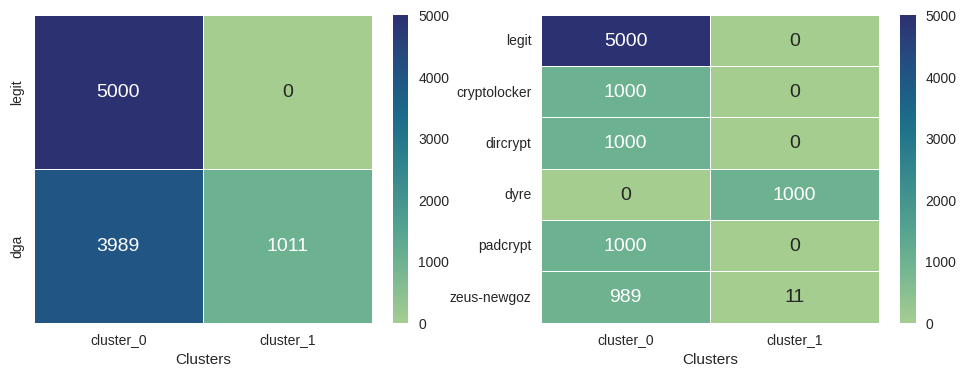

In [25]:
#kmeans con il k scelto
k=2 #da cambiare
kmeans=KMeans(n_clusters=k)
cluster=kmeans.fit(embedded_domain_names)
pred_labels=cluster.labels_
silhouette = silhouette_score(embedded_domain_names, pred_labels, metric="euclidean")
homogeneity_two, completeness_two, v_measure_two = homogeneity_completeness_v_measure(true_labels_biclass, 
                                                                                      pred_labels)
homogeneity_multi, completeness_multi, v_measure_multi = homogeneity_completeness_v_measure(true_labels_multi, 
                                                                                      pred_labels)
print("Stats KMeans:")
print(f"Silhouette: {silhouette}")
print(f"Homogeneity with two classes: {homogeneity_two}")
print(f"Completeness with two classes: {completeness_two}")
print(f"V-measure with two classes: {v_measure_two}")
print(f"Homogeneity with six classes: {homogeneity_multi}")
print(f"Completeness with six classes: {completeness_multi}")
print(f"V-measure with six classes: {v_measure_multi}")
df_two = pd.DataFrame({'Labels': true_labels_biclass, 'Clusters': pred_labels})
ct_two = pd.crosstab(df_two['Labels'], df_two['Clusters'])
ct_labelled_two = ct_two.set_index(pd.Index(["legit", "dga"])).rename(
    columns={i: f"cluster_{i}" if i != -1 else "cluster_noise" for i in ct_two.columns})
df_multi = pd.DataFrame({'Labels': true_labels_multi, 'Clusters': pred_labels})
ct_multi = pd.crosstab(df_multi['Labels'], df_multi['Clusters'])
ct_labelled_multi = ct_multi.set_index(pd.Index([family for family, i in family_dict.items()])).rename(
    columns={i: f"cluster_{i}" if i != -1 else "cluster_noise" for i in ct_multi.columns})
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(ct_labelled_two, annot=True, linewidths=.5, fmt="d", cmap='crest', annot_kws={"size": 14},
                cbar_kws={"shrink": 1}, xticklabels=True, yticklabels=True)
plt.subplot(1,2,2)
sns.heatmap(ct_labelled_multi, annot=True, linewidths=.5, fmt="d", cmap='crest', annot_kws={"size": 14},
                cbar_kws={"shrink": 1}, xticklabels=True, yticklabels=True)

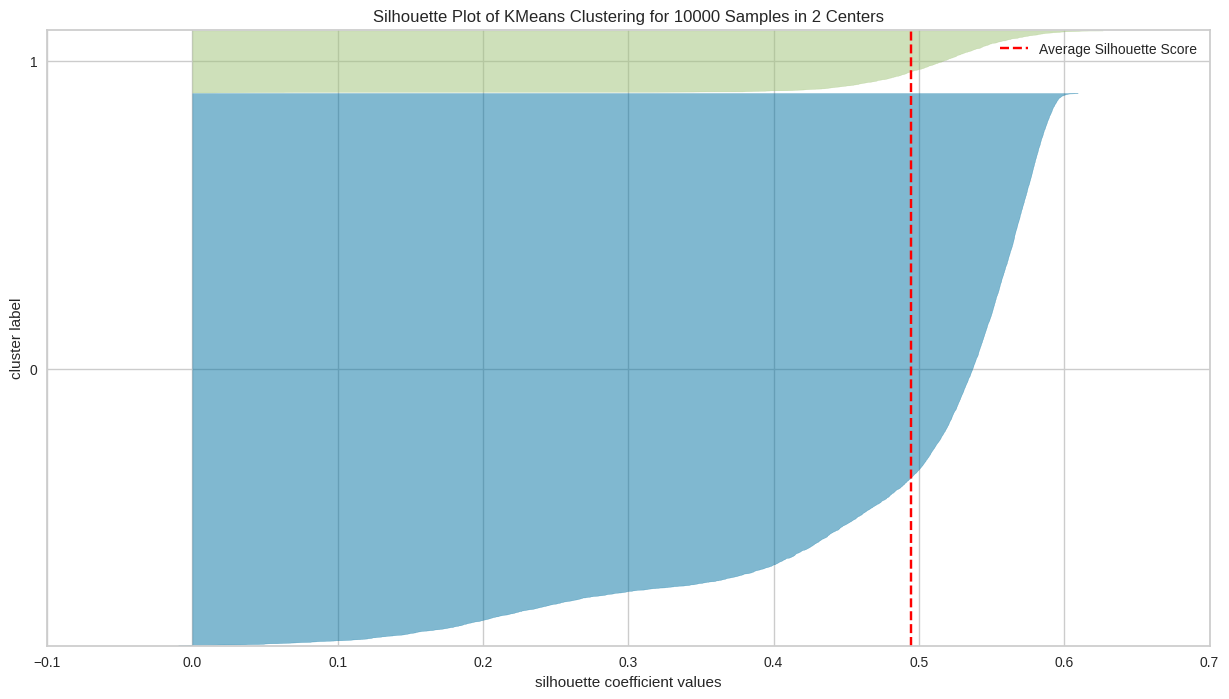

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
# visualizzare la silhouette del kmeans
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
plt.figure(figsize=(15,8))
embedded_domain_names_df = pd.DataFrame(np.array(embedded_domain_names), dtype=float)
visualizer.fit(embedded_domain_names_df)        # Fit the data to the visualizer
visualizer.show() 

In [28]:
cts_two = []
cts_multi = []
for min_samples in range(106,213,53):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(embedded_domain_names)
    distances, indices = neighbors_fit.kneighbors(embedded_domain_names)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
    eps=kneedle.knee_y
    dbscan=DBSCAN(eps=eps, min_samples=min_samples)
    cluster=dbscan.fit(embedded_domain_names)
    pred_labels=cluster.labels_
    n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
    n_noise = list(pred_labels).count(-1)
    silhouette = silhouette_score(embedded_domain_names, pred_labels, metric="euclidean")
    homogeneity_two, completeness_two, v_measure_two = homogeneity_completeness_v_measure(true_labels_biclass, 
                                                                                      pred_labels)
    homogeneity_multi, completeness_multi, v_measure_multi = homogeneity_completeness_v_measure(true_labels_multi, 
                                                                                      pred_labels)
    print(f"Stats DBScan. min_samples={min_samples}, eps={eps}:")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Silhouette: {silhouette}")
    print(f"Homogeneity with two classes: {homogeneity_two}")
    print(f"Completeness with two classes: {completeness_two}")
    print(f"V-measure with two classes: {v_measure_two}")
    print(f"Homogeneity with six classes: {homogeneity_multi}")
    print(f"Completeness with six classes: {completeness_multi}")
    print(f"V-measure with six classes: {v_measure_multi}")
    print("")#vado a capo
    df_two = pd.DataFrame({'Labels': true_labels_biclass, 'Clusters': pred_labels})
    ct_two = pd.crosstab(df_two['Labels'], df_two['Clusters'])
    ct_labelled_two = ct_two.set_index(pd.Index(["legit", "dga"])).rename(
        columns={i: f"cluster_{i}" if i != -1 else "cluster_noise" for i in ct_two.columns})
    cts_two.append(ct_labelled_two)
    df_multi = pd.DataFrame({'Labels': true_labels_multi, 'Clusters': pred_labels})
    ct_multi = pd.crosstab(df_multi['Labels'], df_multi['Clusters'])
    ct_labelled_multi = ct_multi.set_index(pd.Index([family for family, i in family_dict.items()])).rename(
        columns={i: f"cluster_{i}" if i != -1 else "cluster_noise" for i in ct_multi.columns})
    cts_multi.append(ct_labelled_multi)

Stats DBScan. min_samples=106, eps=6.064373238201686:
Number of clusters: 2
Number of noise points: 622
Silhouette: 0.37586718797683716
Homogeneity with two classes: 0.18386686605943942
Completeness with two classes: 0.2311820891700938
V-measure with two classes: 0.2048275302910793
Homogeneity with six classes: 0.32310913786490403
Completeness with six classes: 0.8779049389473211
V-measure with six classes: 0.4723660004110998

Stats DBScan. min_samples=159, eps=6.064373238201686:
Number of clusters: 2
Number of noise points: 834
Silhouette: 0.3859557807445526
Homogeneity with two classes: 0.21218663324652784
Completeness with two classes: 0.2439562110816432
V-measure with two classes: 0.2269650734748849
Homogeneity with six classes: 0.3717418778327733
Completeness with six classes: 0.9235977954174017
V-measure with six classes: 0.5301157463496661

Stats DBScan. min_samples=212, eps=6.064373238201686:
Number of clusters: 2
Number of noise points: 885
Silhouette: 0.38779720664024353
Homo

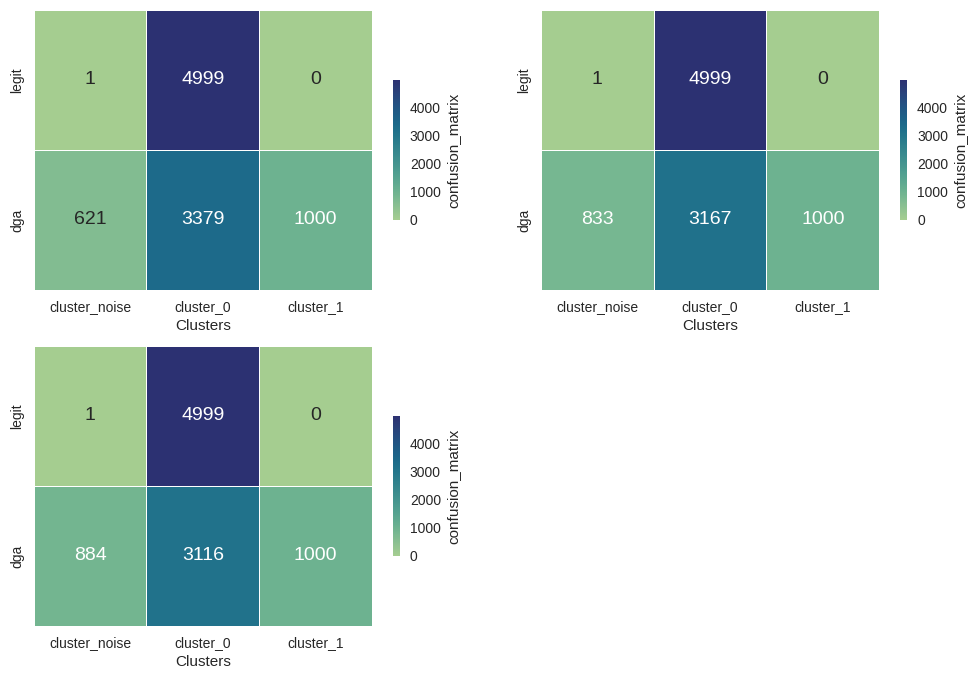

In [30]:
# print confusion matrices for clustering biclass
plt.figure(figsize=(12,8))
for i in range(len(cts_two)):
    plt.subplot(2,2, i+1)
    sns.heatmap(cts_two[i], annot=True, linewidths=.5, fmt="d", cmap='crest', annot_kws={"size": 14},
                cbar_kws={"shrink": 0.5, "label": f"confusion_matrix"}, xticklabels=True, yticklabels=True)

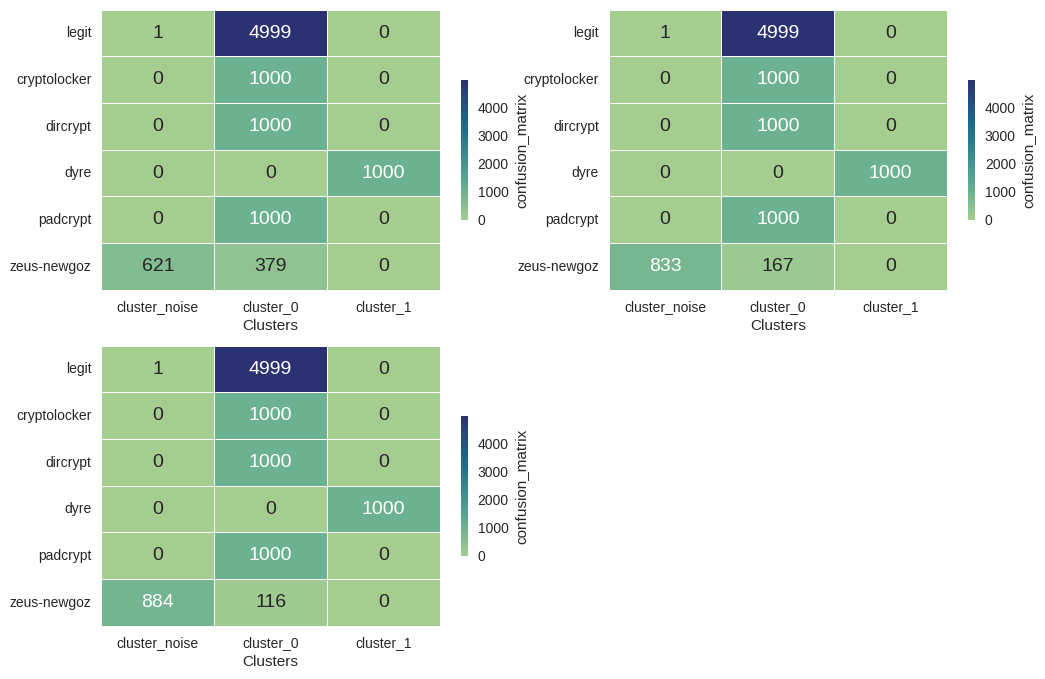

In [31]:
# print confusion matrices for clustering multiclass
plt.figure(figsize=(12,8))
for i in range(len(cts_multi)):
    plt.subplot(2,2, i+1)
    sns.heatmap(cts_multi[i], annot=True, linewidths=.5, fmt="d", cmap='crest', annot_kws={"size": 14},
                cbar_kws={"shrink": 0.5, "label": f"confusion_matrix"}, xticklabels=True, yticklabels=True)